## 4.10 实战Kaggle比赛：预测房价
之前我们学习了一些训练深度网络的基本工具和网络正则化的技术(如权重衰减、暂退法等)。本节我们将通过Kaggle比赛，将所学知识付诸实践。Kaggle的房价预测比赛是一个很好的起点。此数据集由Bart de Cock于2011年收集，涵盖了2006-2010年期间亚利桑那州埃姆斯市是一个很好的起点。这个数据集是相当通用的，不会需要使用复杂模型架构。

本节我们将详细介绍数据预处理、模型设计和超参数选择。

### 4.10.1 下载和缓存数据集
在整本书中，我们将下载不同的的数据集，并训练和测试模型。这里我们实现几个函数来方便下载数据。首先，我们建立字典`DATA_HUB`，他可以将数据集名称的字符串映射到数据集相关的二元组上，这个二元组包含数据集的`url`和验证文件完整性的`sha-l`密钥。所有类似的数据集都拖管在地址为`DATA_URL`的站点上。

In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的`download`函数用来下载数据集，将数据集缓存在本地目录(默认情况../data)中，并返回下载文件的名称。如果缓存目录中已经存在此数据集文件，并且其`sha-l`与存储在`DATA_HUB`中的相匹配，我们将使用缓存的文件，以避免重复下载

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')): #@save
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还需要实现两个实用函数：一个将下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。

In [4]:
def download_extract(name, folder=None): #@save
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'

    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all(): #@save
    for name in DATA_HUB:
        download(name)

### 4.10.2 Kaggle
Kaggle73是⼀个当今流⾏举办机器学习⽐赛的平台，每场⽐赛都以⾄少⼀个数据集为中⼼。许多⽐赛有赞助⽅，他们为获胜的解决⽅案提供奖⾦。该平台帮助⽤⼾通过论坛和共享代码进⾏互动，促进协作和竞争。虽然排⾏榜的追逐往往令⼈失去理智：有些研究⼈员短视地专注于预处理步骤，⽽不是考虑基础性问题。但⼀个客观的平台有巨⼤的价值：该平台促进了竞争⽅法之间的直接定量⽐较，以及代码共享。

### 4.10.3 访问和读取数据集
注意，竞赛数据分为训练集和测试集。每条记录都包括房屋的属性值和属性，如街道类型、施工年份、屋顶类型、地下室状况等。这些特征由各种数据类型组成。例如，建筑年份由整数表示，屋顶类型由离散类别表示，其他特征由浮点数表示。

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [6]:
DATA_HUB['kaggle_house_train'] = (#@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (#@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


训练数据集包括1460个样本，每个样本80个特征和1个标签，而测试数据集包含1459个样本，每个样本80个特征

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


我们可以看到，在每个样本中，第一个特征是ID，这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 4.10.4 数据预处理
如上所述，我们有各种各样的数据类型。在开始建模之前，我们需要对数据进行预处理。首先，我们将所有缺失的值替换相应特征的平均值。然后，为了将所有特征放在一个共同的尺度，我们通过将特征重新缩放到零均值和单位方差来标准化数据：
$$
x \leftarrow \frac{x- \mu}{\sigma}
$$
其中$\mu$和$\sigma$分别表示均值和标准差。现在，这些特征具有零均值和单位方差，即$E[\frac{x-\mu}{\sigma}]= \frac{\mu - \mu}{\sigma}=0$和$E[(x-\mu^2)=(\sigma^2 + \mu^2)-2 \mu^2 + \mu^2 = \sigma^2$。直观地说，我们标准化数据有两个原因：首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。

In [11]:
#若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)

#在标准化数据之后，所有均值消失，因为我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来，我们处理离散值。

In [12]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [14]:
n_trian = train_data.shape[0]
train_features = torch.tensor(all_features[:n_trian].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_trian:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### 4.10.5训练
首先，我们训练一个带有损失平方的线性模型。显然线性模型很难让我们在竞赛中获胜，但线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这里不能做的比随机猜测更好，那么我们很可能存在数据处理错误。如果一切顺利，线性模型将作为基线(baseline)模型，让我们直观地知道最好的模型有超出简单的模型多少

In [15]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

解决这个问题的一种方法是使用价格预测的对数来衡量差异。事实上，这也是比赛官方用来评价提交质量的误差指标。即将$\delta for \mid log y - log \hat y \mid ≤ \delta$ 转换为$e^{- \delta}≤ \frac{\hat y}{y} ≤ e^{\delta}$。这使得预测价格的对数与真实标签价格的对数之间出现均方根误差：
$$ 
\sqrt {\frac{1}{n} \sum_{i=1}^{n} (log y_i - log \hat y_i)^2}
$$

In [16]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rsme = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rsme.item()

In [22]:
def train(net, train_features, train_labels, test_features, test_labels,
        num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### 4.10.6 K折交叉验证
我们首先需要定义一个函数，在K折交叉验证过程中返回第$i$折的数据。具体地说，它选择第$i$个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，会有其他解决办法

In [18]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [19]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rsme',
                        xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i+1}, 训练log rsme{float(train_ls[-1]):f},' 
            f'验证log rsme{float(valid_ls[-1]):f}')

    return train_l_sum / k, valid_l_sum / k 

### 4.10.7 模型选择



折1, 训练log rsme0.170252,验证log rsme0.156968
折2, 训练log rsme0.162046,验证log rsme0.190055
折3, 训练log rsme0.164002,验证log rsme0.168234
折4, 训练log rsme0.167876,验证log rsme0.154263
折5, 训练log rsme0.162521,验证log rsme0.182565
5-折验证:平均训练log rsme: 0.165339,平均验证 log rmse : 0.170417


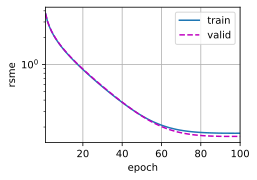

In [23]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证:平均训练log rsme: {float(train_l):f},'
        f'平均验证 log rmse : {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但K折交叉验证的误差要高得多，这表明模型过拟合。在整个训练过程中，你将希望监控训练误差和验证误差这两个数字。较少的过拟合可能表明现有数据可以支撑一个更强大的模型，较大的过拟合可能意味着我们可以通过正则化技术来获益。

### 4.10.8 提交你的Kaggle预测
既然我们知道应该选择什么样的超参数，我们不妨使用所有数据对其进行训练(而不是仅使用交叉验证中使用的1-1/K的数据)。然后，我们通过这种方式获得的模型可以应用于测试集。将预测保存在CSV文件中以简化将结果上传到Kaggle的过程。

In [26]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs+1), [train_ls], xlabel='epoch', ylabel='log rsme', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rsme: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])

    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('Submission.csv', index=False)

训练log rsme: 0.162484


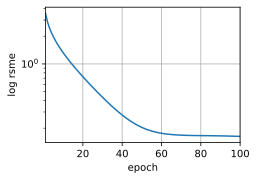

In [27]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

接下来，就是上传Kaggle，并查看在测试集上的预测和实际房价的比较情况。